# Assignment 2

## Part 1: Image Processing Basics

Computers use tiny dots called _pixels_ to display images. Each pixel is stored as an array of numbers that represent color intensities.

__Example.__ In an 8-bit grayscale image, each pixel is a single number. The number represents light intensity ranging from black (0) to white (255).

__Example.__ In a 24-bit RGB color image, each pixel is an array of 3 numbers. These numbers range from 0 to 255 and represent red, green, and blue intensity, respectively. For instance, `(0, 0, 255)` is <span style="color:#00F">bright blue</span> and `(255, 128, 0)` is <span style="color:#FF8000">orange</span>.

In this assignment, you'll use Python and NumPy to manipulate 24-bit RGB color images.

You can use `Image.open()` from the Python imaging library (PIL) to open an image:

In [2]:
import sys
sys.version

'2.7.12 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:43:17) \n[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]'

In [3]:
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np

# Cat image from https://unsplash.com/photos/FqkBXo2Nkq0
cat_img = Image.open("cat.png", "r")

Images display inline in Jupyter notebooks:

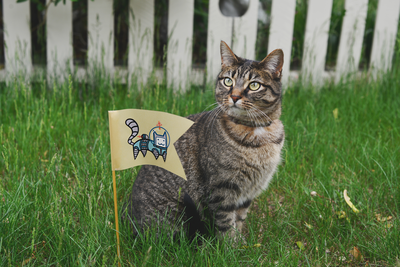

In [4]:
from IPython.display import Image 
Image("cat.png")

In a Python terminal, you can display the image in a new window with `.show()` instead.

NumPy can convert images to arrays:

In [5]:
cat = np.array(cat_img)

To convert an array back to an image (for display) use the function below:

In [6]:
def as_image(x):
    """Convert an ndarray to an Image.
    
    Args:
        x (ndarray): The array of pixels.
        
    Returns:
        Image: The Image object.
    """
    return Image.fromarray(np.uint8(x))

__Exercise 1.1.__ How many dimensions does the `cat` array have? What does each dimension represent?

In [7]:
cat.shape

(267, 400, 3)

The cat array has 3 dimensions. The array contains 267 arrays, each of which is itself an array of 400 arrays of length 3. The image contains 400x267 pixels, and each pixel has 3 numbers representing it. 

__Exercise 1.2.__ Use `.copy()` to copy the cat array to a new variable. Swap the green and blue color channels in the copy. Display the result.

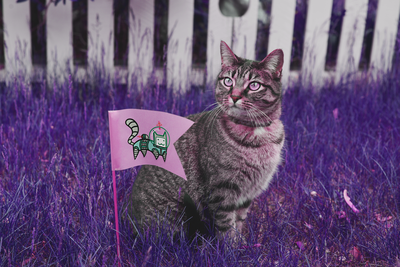

In [8]:
copy_cat = cat.copy()
copy_cat[:,:,[1,2]] = copy_cat[:,:,[2,1]]
from PIL import Image

img = Image.fromarray(copy_cat, 'RGB')
img.save('copy_cat.png')

from IPython.display import Image 
Image("copy_cat.png")

__Exercise 1.3.__ Why is `.copy()` necessary in exercise 1.2? What happens if you don't use `.copy()`?

If we don't use .copy() we would be making these changes to the original image. If we want to preserve the original image, we need to make a copy so we can make edits to the copy instead. 

__Exercise 1.4.__ Flip the blue color channel from left to right. Display the resulting image. _Hint: see the NumPy documentation on array manipulation routines._

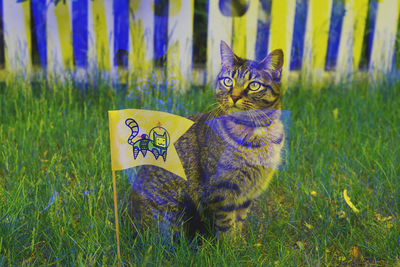

In [9]:
copy_cat2 = cat.copy()

copy_cat2[:,:,2] = np.fliplr(cat[:,:,2])
from PIL import Image

img = Image.fromarray(copy_cat2, 'RGB')
img.save('copy_cat2.png')

from IPython.display import Image 
Image("copy_cat2.png")

## Part 2: Singular Value Decomposition

Suppose $X$ is an $n \times p$ matrix (for instance, one color channel of the cat image). The _singular value decomposition_ (SVD) factors $X$ as $X = UD V^T$, where:

* $U$ is an $n \times n$ orthogonal matrix
* $D$ is an $n \times p$ matrix with zeroes everywhere except the diagonal
* $V$ is an $p \times p$ orthogonal matrix

Note that a matrix $A$ is _orthogonal_ when $A^T A = I$ and $AA^T = I$.

__Example.__ We can use NumPy to compute the SVD for a matrix:

In [10]:
x = np.array(
    [[0, 2, 3],
     [3, 2, 1]]
)
u, d, vt = np.linalg.svd(x)
# Here d is 2x2 because NumPy only returns the diagonal of D.
print "u is:\n", u, "\nd is:\n", d, "\nv^T is:\n", vt

u is:
[[-0.68145174 -0.73186305]
 [-0.73186305  0.68145174]] 
d is:
[ 4.52966162  2.54600974] 
v^T is:
[[-0.48471372 -0.62402665 -0.6128975 ]
 [ 0.80296442 -0.03960025 -0.59470998]
 [ 0.34684399 -0.78039897  0.52026598]]


If we let

* $u_i$ denote the $i$th column of $U$
* $d_i$ denote the $i$th diagonal element of $D$
* $v_i$ denote the $i$th column of $V$

then we can write the SVD as $\ X = UDV^T = d_1 u_1 v_1^T + \ldots + d_m u_m v_m^T\ $ using the rules of matrix multiplication. In other words, the SVD decomposes $X$ into a sum!

If we eliminate some of the terms in the sum, we get a simple approximation for $X$. For instance, we could eliminate all but first 3 terms to get the approximation $X \approx d_1 u_1 v_1^T + d_2 u_2 v_2^T + d_3 u_3 v_3^T$. This is the same as if we:

* Zero all but the first 3 diagonal elements of $D$ to get $D_3$, then compute $X \approx UD_3V^T$
* Eliminate all but the first 3 columns of $V$ to get $p \times 3$ matrix $V_3$, then compute $X \approx UDV_3^T$

We always eliminate terms starting from the end rather than the beginning, because these terms contribute the least to $X$.

Why would we want to approximate a matrix $X$?

In statistics, _principal components analysis_ uses this approximation to reduce the dimension (number of covariates) in a  centered (mean 0) data set. The vectors $d_i u_i$ are called the _principal components_ of $X$. The vectors $v_i^T$ are called the _basis vectors_. Note that both depend on $X$. The dimension is reduced by using the first $q$ principal components instead of the original $p$ covariates. In other words, the $n \times p$ data $X$ is replaced by the $n \times q$ data $UD_q = XV_q$

In computing, this approximation is sometimes used to reduce the number of bits needed to store a matrix (or image). If $q$ terms are kept, then only $nq + pq$ values (for $XV_q$ and $V_q^T$) need to be stored instead of the uncompressed $np$ values.

__Exercise 2.1.__ Write the functions described below.

* A function that takes a matrix $X$ and returns its principal component matrix $XV_q$ and basis matrix $V_q^T$. This function should also take the number of terms kept $q$ as an argument.

* A function that takes a principal component matrix $XV_q$ and basis matrix $V_q^T$ and returns an approximation $\hat{X}$ for the original matrix.

As usual, make sure to document your functions. Test your function on the red color channel of the cat image. What's the smallest number of terms where the cat is still recognizable as a cat?

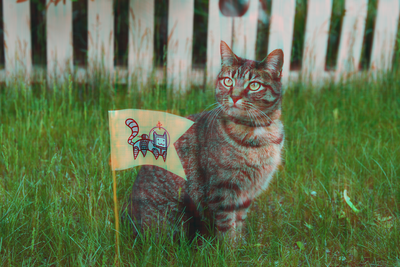

In [12]:
def pc_decomp(x,q):
    """Compute SVD of X, then return principal component matrix XVq and VqT"""
    u, d, vt = np.linalg.svd(x)
    vq = vt.T[:,:q]
    vtq = vq.T
    xvq = x.dot(vq)

    return xvq, vtq

def approx(xvq, vtq):
    """Compute an approximation for X using xvq and vtq"""
    return xvq.dot(vtq)

#Testing the code
test_cat = cat.copy()
red_cat = test_cat[:,:,0]
xvq, vtq = pc_decomp(red_cat,10)

red_cat_approx = approx(xvq, vtq)

test_cat[:,:,0] = red_cat_approx

from PIL import Image

img = Image.fromarray(test_cat, 'RGB')
img.save('test_cat.png')

from IPython.display import Image 
Image("test_cat.png")

The image doesn't get more or less blury with changes to q. Only the colors change. When q = 0, the image consists only of blue and green, but you can still see a cat. 

__Exercise 2.2.__ You can check the number of bytes used by a NumPy array with the `.nbytes` attribute. How many bytes does the red color channel of the cat image use? How many bytes does the compressed version use when 10 terms are kept? What percentage of the original size is this?

In [49]:
r1 = cat[:,:,0]
print r1.nbytes
print xvq.nbytes + vtq.nbytes
print (float(xvq.nbytes+vtq.nbytes)/float(r1.nbytes))*100

106800
53360
49.9625468165


We have reduced the number of bytes stored by 49.9%